In [7]:
import sys
!{sys.executable} -m pip install pyarrow

     ---------------------------------------- 21.5/21.5 MB 8.3 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [29]:
class ProcessGameState():
    def __init__(self, filename):
        self.df = pd.read_parquet(filename, engine='pyarrow')

    def checkBoundary(self,c, boundary): # uses the raycast odd number rule to detect if a point is within the boundaries of a polygon
        x,y,z = c
        if z>421 or z<285: # first check z bound
            return False
        else: # then implement raycast algorithm
            count = 0
            
            for edge in boundary:
                (x1, y1), (x2, y2) = edge
                if (y < y1) != (y<y2) and x < x1 + ((y-y1)/(y2-y1))*(x2-x1):
                    count +=1

            return count%2 == 1

    def getBoundaryRows(self, boundary): # get rows filtered by certain boundary given edges of said boundary
        withinBoundary = []
        for row in self.df.iterrows():
            c = (row[1].x, row[1].y, row[1].z) # create list to hold singular xyz coordinates for each row
            if self.checkBoundary(c, boundary):
                 withinBoundary.append(row[0])
        return withinBoundary # return list of all rows that fall within the given boundary
    
    def getRows(self, area, team, side): # get rows filtered by area, team, and side
        rows = []
        for row in self.df.iterrows():
            row = row[1]
            if ((area == row['area_name']) and (team == row['team']) and (side == row['side']) and (row['is_alive'])):
                rows.append(row)
        return rows

In [5]:
p1 = ProcessGameState('game_state_frame_data.parquet') #name of file here
boundary_points = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580], [-1735, 250], [-1735, 250]]
boundary = [((-1735, 250),(-2024,398)), ((-2024,398), (-2806, 742)),((-2806,742), (-2472, 1233)), ((-2472, 1233),(-1565, 580)), ((-1565, 580), (-1735,250))] #edges of boundary defined here
rows = p1.getBoundaryRows(boundary)
coords = []
coordsT = []
for i in rows:
    row = p1.df.iloc[i]
    player = row['player']
    team = row['team']
    side = row['side']
    isAlive = row['is_alive']
    r = row['round_num']
    area = row['area_name']
    x, y= row['x'], row['y']
    coords.append((x,y))
    
    if team == "Team2" and side == 'T': # filtering for rows concerning Team2 on T side
        print(str(r) +" " +player)
        coordsT.append((x,y))

16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9


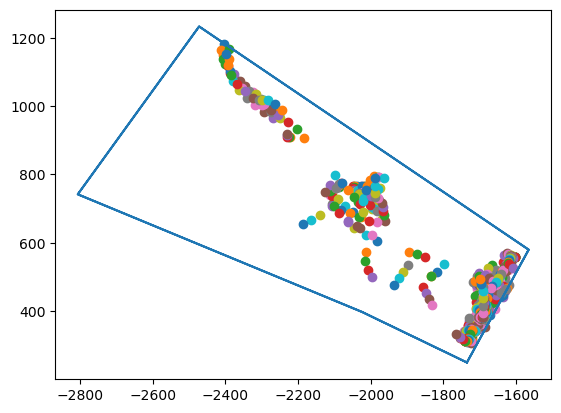

In [48]:
for coord in coords: #scatter plot for all rows with coordinates in boundary
    plt.scatter(coord[0], coord[1])
for point in boundary_points: #showing the boundary
    xs.append(point[0])
    ys.append(point[1])
    
plt.plot(xs, ys)



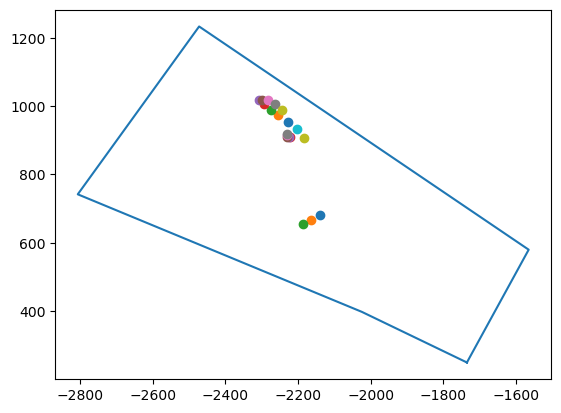

In [49]:
xs = []
ys = []
for coord in coordsT:
    plt.scatter(coord[0], coord[1])
for point in boundary_points: #showing the boundary
    xs.append(point[0])
    ys.append(point[1])
plt.plot(xs, ys)

According to the above output, Team 2 only ever entered the area of interest during 1 round with 2 of their players.
Thus it appears that attacking through the light blue boundary was not a common strategy for Team 2 on T side

In [34]:

def extractWeaponClass(row): # extract weapon types from row
    inventory = row['inventory']
    item_types = []
    for item in inventory:
        item_types.append(item['weapon_class'])
    return item_types
        
def enterArea(round, rows, gunCount):
    rifleSMGCount = 0 #variable to keep track of number of rifles and SMGs held by players
    attackDict = {}
    for row in rows:
        key = (row['player'], row['round_num']) #tuple that stores player and round number to store in dict
        if not key in dict.keys(): #only concerned with the first instance so we can learn the time that players enter an area
            dict.[key] = row['seconds'] 
            weapons = extractWeaponClass(row)
            if (('SMG' in weapons) or ('Rifle' in weapons)):
                rifleSMGCount + =1

Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 16
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21
Player5 21

In [ ]:
bSiteTRows = p1.getRows('BombsiteB', 'Team2', 'T') # get all rows from Team2 on T side on BombsiteB

timer = enterArea(round, bSiteRows, 2) # get 

6030


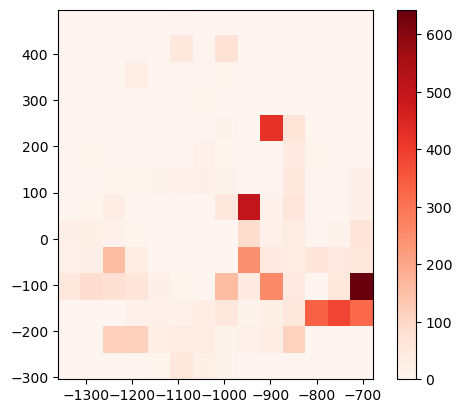

In [47]:
from matplotlib.pyplot import cm
bSiteCTRows = p1.getRows('BombsiteB', 'Team2', 'CT')
x = []
y = []
for rows in bSiteCTRows:
    x.append(rows['x'])
    y.append(rows['y'])
print(len(x))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=14) 
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]  
plt.clf()  
plt.imshow(heatmap, extent=extent, cmap=cm.Reds)  
plt.colorbar()
plt.show() 